In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(here()))
except ModuleNotFoundError:
    import os
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")
    
finally:
    # import library functions
    from rbig_jax.data import get_classic
    from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss
    from rbig_jax.information.entropy import rbig_multivariate_entropy

In [2]:
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


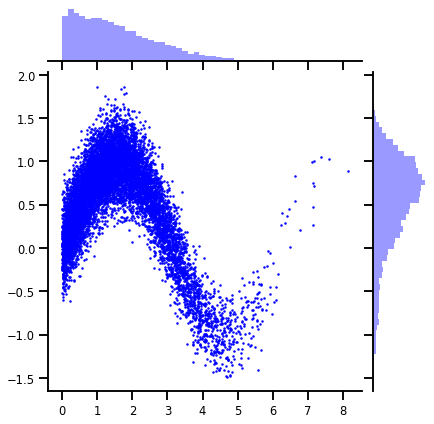

In [3]:
n_samples = 10_000
data = get_classic(n_samples)

X = np.array(data, dtype=np.float32)

sns.jointplot(data[:, 0], data[:, 1], color="blue", s=1)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [4]:
%%time

zero_tolerance = 20

H_X_rbig = rbig_multivariate_entropy(
    X=X.block_until_ready(),
    zero_tolerance=zero_tolerance,
)

print(f"RBIG H: {H_X_rbig:.5f}")

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
RBIG H: 2.58197
CPU times: user 8.4 s, sys: 430 ms, total: 8.83 s
Wall time: 8.11 s


## High-Dimensional Entropy Example

In [5]:
#Parameters
n_samples = 10_000
d_dimensions = 10

seed = 123

rng = onp.random.RandomState(seed)

# Generate random normal data
data_original = rng.randn(n_samples, d_dimensions)

# Generate random Data
A = rng.rand(d_dimensions, d_dimensions)

data = data_original @ A

In [6]:
from rbig_jax.information.entropy import histogram_entropy

nbins = int(np.sqrt(n_samples))
base = 2

Hx = jax.vmap(histogram_entropy, in_axes=(1, None, None))(data, base, nbins).sum()

print(f"Hx: {Hx.sum() * np.log(2):.4f}")

H_original = Hx.sum() + np.log2(np.abs(np.linalg.det(A)))

print(f"H: {H_original:.4f}")

Hx: 19.9376
H: 22.7575


## RBIG Approximate Solution

In [7]:
%%time

X = np.array(data, dtype=np.float32)
zero_tolerance = 20

H_X_rbig = rbig_multivariate_entropy(
    X=X.block_until_ready(),
    zero_tolerance=zero_tolerance,
)

print(f"RBIG H: {H_X_rbig:.5f}")

RBIG H: 21.89816
CPU times: user 10.4 s, sys: 2.63 s, total: 13 s
Wall time: 9.39 s
